# K-Means Clustering

Tutorials:
- https://365datascience.com/tutorials/python-tutorials/pca-k-means/ 
- https://medium.com/@messenger_g/k-means-clustering-on-pca-transformed-ecological-data-python-scikit-learn-9e982a1a2b15

## Dependencies

In [2]:
# %pip install pandas numpy seaborn matplotlib scikit-learn kneed ipywidgets

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from kneed import KneeLocator
from ipywidgets import interact

In [3]:
sns.set_theme(style="whitegrid")                         # set seaborn theme

In [4]:
# Define possible dataset paths.
paths = [
    '../datasets/_integrated_data/missing-pollutant-values-filled-somehow/data.csv',                    # 0  - Annual  :
    '../datasets/_integrated_data/missing-pollutant-values-filled-somehow/data-gendered.csv',           # 1  - Annual  : Gendered
    '../datasets/_integrated_data/monthly/missing-pollutant-values-filled-somehow/data.csv',            # 2  - Monthly :
    '../datasets/_integrated_data/monthly/missing-pollutant-values-filled-somehow/data-gendered.csv'    # 3  - Monthly : Gendered
]

chosen_dataset = 1                                       # Choose the dataset to be used.
df = pd.read_csv(paths[chosen_dataset])                  # Read the dataset.
df.info()                                                # Display dataset information.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   financial year               130 non-null    object 
 1   lhd                          130 non-null    object 
 2   CO ppm                       130 non-null    float64
 3   NO pphm                      130 non-null    float64
 4   NO2 pphm                     130 non-null    float64
 5   OZONE pphm                   130 non-null    float64
 6   PM10 µg/m³                   130 non-null    float64
 7   SO2 pphm                     130 non-null    float64
 8   asthma edp [f]               130 non-null    float64
 9   asthma edp [m]               130 non-null    float64
 10  asthma hospitalisations [f]  130 non-null    float64
 11  asthma hospitalisations [m]  130 non-null    float64
 12  copd deaths [f]              130 non-null    float64
 13  copd deaths [m]     

In [5]:
# Drop the date and local health district columns
df = df.drop(columns=df.columns[:2])                                                                   # Drop the first 2 columns

# Extract pollutant columns
possible_pollutants = ['CO ppm', 'NO pphm', 'NO2 pphm', 'OZONE pphm', 'PM10 µg/m³', 'SO2 pphm']        # Possible features
pollutant_columns = [col for col in df.columns if col in possible_pollutants]                          # Extract pollutant columns

# Extract health stat columns
health_stat_columns = [col for col in df.columns if col not in pollutant_columns]                           # Extract health stat columns

In [6]:
# Scale pollutant data.
scaler = StandardScaler()                                                                              # Create a scaler
pollutant_columns_scaled = scaler.fit_transform(df[pollutant_columns])                                 # Scale pollutant columns

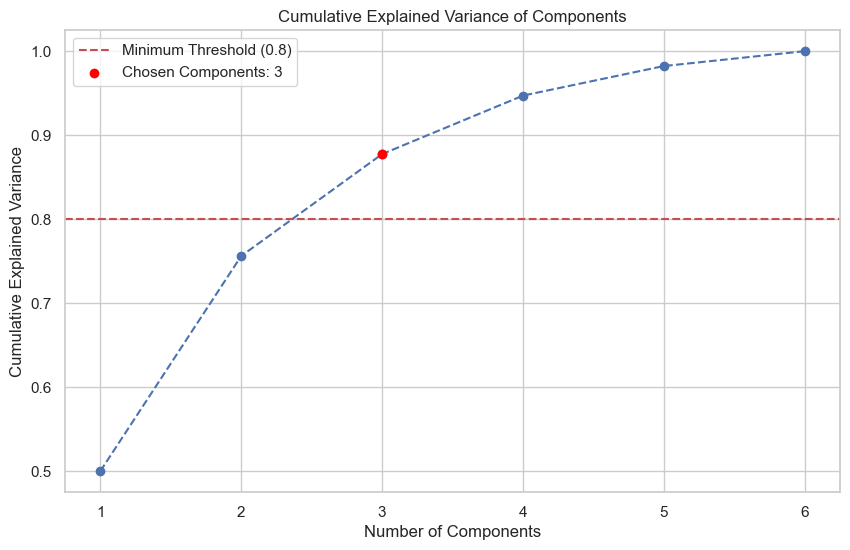

In [7]:
# Find the optimal number of clusters.
pca = PCA()                                                                                            # Create a PCA object
pca.fit(pollutant_columns_scaled)                                                                      # Fit the PCA object to the scaled pollutant columns
explained_variance = pca.explained_variance_ratio_                                                     # Extract the explained variance of components

# Print the explained variance of components.
cumulative_variance = 0                                                                                # Set the cumulative variance to 0
n_components = None                                                                                    # Set the number of components to None

# Find the number of components that explain at least 80% of the variance.
for i, variance in enumerate(explained_variance):                                                      # Iterate over the explained variance
    cumulative_variance += variance                                                                    # Add the variance to the cumulative variance
    if cumulative_variance >= 0.8 and n_components is None:                                            # If the cumulative variance is at least 0.8 and the number of components is None
        n_components = i + 1                                                                           # Set the number of components to the current index + 1
        break                                                                                          # Break the loop

# Plot the cumulative explained variance of components.
plt.figure(figsize=(10, 6))                                                                                                                    # Create a figure
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')                                       # Plot the cumulative explained variance
plt.xlabel('Number of Components')                                                                                                             # Set the x-axis label
plt.ylabel('Cumulative Explained Variance')                                                                                                    # Set the y-axis label
plt.title('Cumulative Explained Variance of Components')                                                                                       # Set the title
plt.axhline(y=0.8, color='r', linestyle='--', label='Minimum Threshold (0.8)')                                                                 # Add a horizontal line at 0.8
plt.scatter(n_components, explained_variance.cumsum()[n_components - 1], color='red', label=f'Chosen Components: {n_components}', zorder=5)    # Add a point at the chosen number of components
plt.legend()                                                                                                                                   # Add a legend
plt.show()                                                                                                                                     # Show the plot

In [8]:
# Perform PCA with the chosen number of components.
pca = PCA(n_components=3)                                     # Create a PCA object with the chosen number of components
pca.fit(pollutant_columns_scaled)                             # Fit the PCA object to the scaled pollutant columns
pca.transform(pollutant_columns_scaled)                       # Transform the scaled pollutant columns
scores_pca = pca.transform(pollutant_columns_scaled)          # Extract the transformed pollutant columns

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\matth\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\matth\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\matth\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

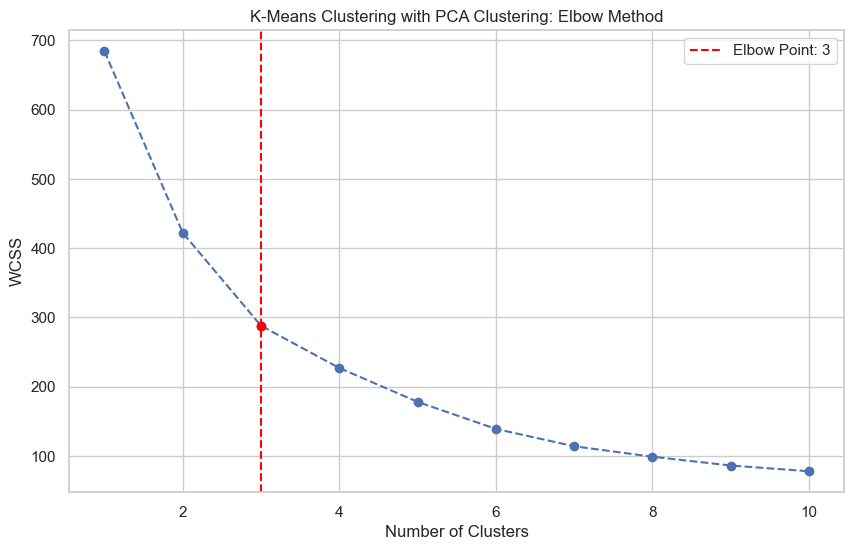

In [9]:
# Use the elbow method to find the optimal number of clusters.
wcss = []                                                                                              # Create an empty list to store the within-cluster sum of squares
for i in range(1, 11):                                                                                 # Iterate over the range from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)           # Create a KMeans object with the current number of clusters
    kmeans.fit(scores_pca)                                                                             # Fit the KMeans object to the PCA scores
    wcss.append(kmeans.inertia_)                                                                       # Append the within-cluster sum of squares to the list

# Identify the elbow point using KneeLocator
kl = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')                           # Create a KneeLocator object
elbow = kl.elbow                                                                                       # Extract the elbow point

# Plot the elbow method graph.
plt.figure(figsize=(10, 6))                                                                            # Create a figure
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')                                               # Plot the within-cluster sum of squares
plt.xlabel('Number of Clusters')                                                                       # Set the x-axis label
plt.ylabel('WCSS')                                                                                     # Set the y-axis label
plt.title('K-Means Clustering with PCA Clustering: Elbow Method')                                      # Set the title
plt.axvline(x=elbow, color='red', linestyle='--', label=f'Elbow Point: {elbow}')                       # Add a vertical line at the elbow point
plt.scatter(n_components, wcss[n_components - 1], color='red', zorder=5)                               # Add a point at the chosen number of clusters
plt.legend()                                                                                           # Add a legend
plt.show()                                                                                             # Show the plot

In [10]:
# Perform K-Means clustering with the optimal number of clusters.
kmeans_pca = KMeans(n_clusters=elbow, init='k-means++', max_iter=300, n_init=10, random_state=88)      # Create a KMeans object with the optimal number of clusters
kmeans_pca.fit(scores_pca)                                                                             # Fit the KMeans object to the PCA scores

# Concatenate the original dataframe with the PCA scores and cluster labels.
df = pd.concat([df.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)                          # Concatenate the original dataframe with the PCA scores

# Rename the component columns.
df.columns.values[-n_components:] = [f'component {i+1}' for i in range(n_components)]                  # Rename the columns dynamically based on the number of components

# Add a 'cluster' column to the dataframe and map the cluster labels to more descriptive names.
df['cluster'] = kmeans_pca.labels_                                                                     # Add a 'cluster' column to the dataframe
cluster_labels = {i: f'Cluster {i+1}' for i in range(elbow)}                                           # Create a dynamic mapping for cluster labels
df['cluster'] = df['cluster'].map(cluster_labels)                                                      # Map the cluster labels to more descriptive names

# Display the first few rows of the dataframe.
df.head()                                                                                              # Display the first few rows of the dataframe

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,CO ppm,NO pphm,NO2 pphm,OZONE pphm,PM10 µg/m³,SO2 pphm,asthma edp [f],asthma edp [m],asthma hospitalisations [f],asthma hospitalisations [m],...,copd hospitalisations [f],copd hospitalisations [m],iap deaths [f],iap deaths [m],iap hospitalisations [f],iap hospitalisations [m],component 1,component 2,component 3,cluster
0,0.100000,0.233333,0.466667,1.791190,15.158333,0.050000,373.6,354.3,145.650,86.750,...,277.0,315.9,9.4,11.5,269.0,402.9,-0.609508,-1.142571,-0.314641,Cluster 1
1,0.108333,0.216667,0.458333,1.691667,15.375000,0.058333,405.8,350.7,147.750,91.275,...,301.9,288.7,9.9,10.2,298.5,404.2,-0.374036,-1.098622,-0.309889,Cluster 1
2,0.100000,0.216667,0.491667,1.775000,15.358333,0.058333,412.0,339.7,145.700,87.350,...,312.5,303.7,11.1,11.4,260.3,324.7,-0.521267,-0.996436,-0.419392,Cluster 1
3,0.108333,0.175000,0.441667,1.861183,16.816667,0.075000,386.7,344.0,133.575,89.900,...,298.9,327.5,9.7,13.3,343.6,421.9,-0.683274,-0.296048,-0.415417,Cluster 1
4,0.108333,0.216667,0.416667,1.733333,17.750000,0.091667,403.8,349.0,127.975,84.975,...,307.8,286.2,7.8,13.3,339.6,420.6,-0.404505,-0.042532,-0.493930,Cluster 1


C:\Users\matth\AppData\Local\Temp\ipykernel_13036\3092309305.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x_axis, y_axis, z_axis, c=df['cluster'].map({'Cluster 1': 'g', 'Cluster 2': 'r', 'Cluster 3': 'c'}), cmap='viridis')     # Create a scatter plot
c:\Users\matth\anaconda3\Lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


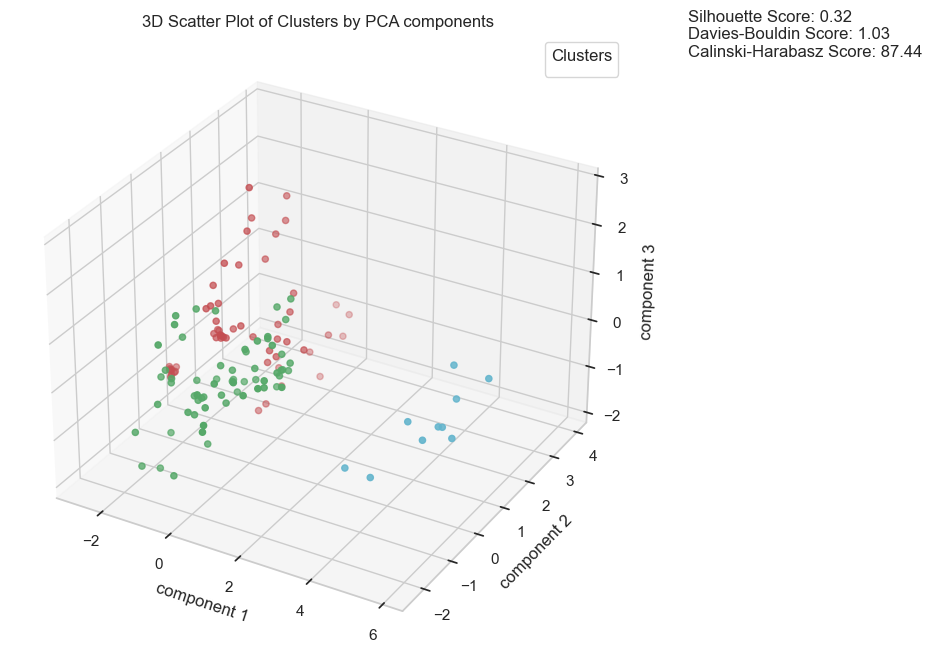

In [11]:
# Visualize the clusters in 2D.
if (n_components == 2):                                                                                # If the number of components is 2
    
    plt.figure(figsize=(10, 6))                                                                        # Create a figure
    sns.scatterplot(x='component 1', y='component 2', hue='cluster', data=df, palette='tab10')         # Create a scatter plot of the clusters
    plt.title('K-Means Clustering with PCA Clustering: 2D Visualization')                              # Set the title
    plt.show()                                                                                         # Show the plot

# Visualize the clusters in 3D.
if (n_components == 3):                                                                                # If the number of components is 3
    fig = plt.figure(figsize=(10, 8))                                                                  # Create a figure
    ax = fig.add_subplot(111, projection='3d')                                                         # Add a 3D subplot

    x_axis = df['component 1']                                                                         # Extract the x-axis
    y_axis = df['component 2']                                                                         # Extract the y-axis
    z_axis = df['component 3']                                                                         # Extract the z-axis

    scatter = ax.scatter(x_axis, y_axis, z_axis, c=df['cluster'].map({'Cluster 1': 'g', 'Cluster 2': 'r', 'Cluster 3': 'c'}), cmap='viridis')     # Create a scatter plot
    ax.set_xlabel('component 1')                                                                       # Set the x-axis label
    ax.set_ylabel('component 2')                                                                       # Set the y-axis label
    ax.set_zlabel('component 3')                                                                       # ! Set the z-axis label
    ax.set_title('3D Scatter Plot of Clusters by PCA components')                                      # Set the title
    ax.legend(*scatter.legend_elements(), title="Clusters")                                            # Add a legend

    # Calculate and display metrics for each cluster
    silhouette_avg = silhouette_score(scores_pca, kmeans_pca.labels_)
    davies_bouldin_avg = davies_bouldin_score(scores_pca, kmeans_pca.labels_)
    calinski_harabasz_avg = calinski_harabasz_score(scores_pca, kmeans_pca.labels_)

    metrics_text = (f"Silhouette Score: {silhouette_avg:.2f}\n"
                    f"Davies-Bouldin Score: {davies_bouldin_avg:.2f}\n"
                    f"Calinski-Harabasz Score: {calinski_harabasz_avg:.2f}")

    ax.text2D(1.1, 1, metrics_text, transform=ax.transAxes, fontsize=12, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))
    plt.show()                                                                                         # Show the plot



# More than 3 components
if (n_components > 3):
    print('Too many components to visualize in 2D or 3D.')                                             # Print a stating that there are too many components to visualize in 2D or 3D
    cluster_summary = df.groupby('cluster').mean()[pollutant_columns + health_columns]                 # Group the dataframe by cluster and calculate the mean of pollutant and health columns
    cluster_summary['Count'] = df['cluster'].value_counts()                                            # Add a 'Count' column to the cluster summary
    cluster_summary = cluster_summary.reset_index()                                                    # Reset the index of the cluster summary

In [12]:
# Define features
target_column = health_stat_columns[1]                                                                 # Set the target column to the first health stat column
x_axis = df[target_column]                                                                             # Set the y-axis to the target column
y_axis = df['cluster']                                                                                 # Set the x-axis to the cluster column

In [13]:
from ipywidgets import interact, widgets

# Function to create subplots for the selected health stat column
def plot_health_stats(target_column):
    plt.close()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

    # Boxplot
    sns.boxplot(x='cluster', y=target_column, data=df, ax=axes[0], palette='tab10')
    axes[0].set_title(f'Clusters by {target_column} Box Plot')
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel(f'{target_column} [rate per 100,000]')

    # Histogram
    min_value = df[target_column].min()
    max_value = df[target_column].max()
    bins = np.arange(int(min_value), int(max_value) + 1, int((max_value - min_value) * 0.1)) 
    clusters = df['cluster'].unique()

    width = np.diff(bins)[0] / (len(clusters) + 1)
    for j, cluster in enumerate(clusters):
        cluster_data = df[df['cluster'] == cluster][target_column]
        cluster_mean = cluster_data.mean()
        bar_positions = bins[:-1] + (j * width)
        axes[1].bar(bar_positions, np.histogram(cluster_data, bins=bins)[0], width=width, label=cluster, alpha=0.7)
        axes[1].axvline(cluster_mean, color=f'C{j}', linestyle='--', label=f'{cluster} Mean')

    axes[1].set_xlabel(f'{target_column} rate per 100,000')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{target_column} by Cluster')
    axes[1].legend()

    # Calculate and display metrics
    cluster_data = df[df['cluster'] == cluster][target_column]
    mean = cluster_data.mean()
    median = cluster_data.median()
    std_dev = cluster_data.std()
    min_val = cluster_data.min()
    max_val = cluster_data.max()

    metrics_text = f"Mean: {mean:.2f}\nMedian: {median:.2f}\nStd Dev: {std_dev:.2f}\nMin: {min_val:.2f}\nMax: {max_val:.2f}"
    axes[1].text(1.05, 1, metrics_text, transform=axes[1].transAxes, fontsize=12, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# Create a dropdown widget for selecting the target column
target_column_widget = widgets.Dropdown(
    options=health_stat_columns,
    value=health_stat_columns[0],
    description='Target Column:',
    disabled=False,
)

# Use the interact function to update the plot based on the selected target column
interact(plot_health_stats, target_column=target_column_widget)


interactive(children=(Dropdown(description='Target Column:', options=('asthma edp [f]', 'asthma edp [m]', 'ast…

<function __main__.plot_health_stats(target_column)>